# Project 1 – Classification, weight sharing, auxiliary losses

The objective of this project is to test **different architectures** to compare two digits visible in a
two-channel image. It aims at showing in particular the impact of **weight sharing**, and of the use of an
auxiliary loss to help the training of the main objective.
It should be implemented with PyTorch only code, in particular without using other external libraries
such as scikit-learn or numpy.
## Data
The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate˙pair˙sets(N) defined in the file
dlc˙practical˙prologue.py. 

This function returns six tensors:

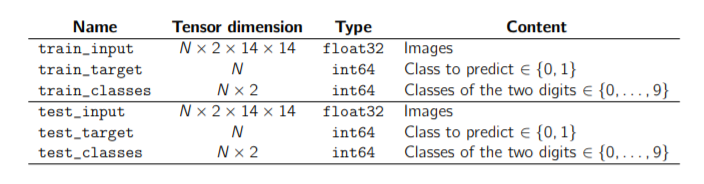

## Objective
The goal of the project is to compare different architectures, and assess the performance improvement that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest. All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000 parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error rate. Performance estimates provided in your report should be estimated through 10+ rounds for each architecture, where both data and weight initialization are randomized, and you should provide estimates of standard deviations

Need to add normalization of the train data. 

### Load the data

In [153]:
import torch
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
N = 1000

%matplotlib inline

In [125]:
train_inputs, train_targets, train_classes, test_inputs, test_targets, test_classes = prologue.generate_pair_sets(N)

# Normalize the training sets
mu, std = train_inputs.mean(), train_inputs.std() 
train_inputs.sub_(mu).div_(std)

# Normalize the test sets
test_inputs.sub_(mu).div_(std)

train_targets, test_targets = train_targets.float(), test_targets.float()

# Creation of dataloaders for minibatches handling
dataset_train = TensorDataset( train_inputs, train_targets, train_classes)
   #dataset_train, dataset_val = torch.utils.data.random_split(dataset_train, [900, 100])
dataset_test = TensorDataset( test_inputs, test_targets, test_classes)

dataloader_train = DataLoader(dataset_train, batch_size = 100, shuffle = False)
   #dataloader_val = DataLoader(dataset_val, batch_size = 10, shuffle = False)
datloader_test = DataLoader(dataset_test, batch_size = 100, shuffle = False)

### Get a sense of it

Let us print the sizes of the tensors:

In [100]:
for name, tensor in zip(['train_input', 'train_target', 'train_classes', 'test_input', 'test_target', 'test_classes'], 
                        [train_inputs, train_targets, train_classes, test_inputs, test_targets, test_classes]):
    print(name, tensor.size())

train_input torch.Size([1000, 2, 14, 14])
train_target torch.Size([1000])
train_classes torch.Size([1000, 2])
test_input torch.Size([1000, 2, 14, 14])
test_target torch.Size([1000])
test_classes torch.Size([1000, 2])


In [101]:
(train_targets == 1).sum().item()

560

Everything looks fine and pretty balanced!

Now let us make sure that the `train_target` really corresponds to the `train_classes`.

In [102]:
# For example, for the first one
print('train_classes are', train_classes[0])
print('train_target is', train_targets[0])

# For example, for the fourth one
print('train_classes are', train_classes[4])
print('train_target is', train_targets[4])

# For example, for the sixth one
print('train_classes are', train_classes[6])
print('train_target is', train_targets[6])

train_classes are tensor([1, 2])
train_target is tensor(1.)
train_classes are tensor([4, 1])
train_target is tensor(0.)
train_classes are tensor([4, 9])
train_target is tensor(1.)


Funny, but everything looks fine!

In [147]:
def train_model(model, dataloader = dataloader_train, test_inputs=None,
                test_targets=None, remember_train_losses=True, remember_test_losses=True, 
                lr=1e-3, nb_epochs=25):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model 
        dataloader : 
        
        test_inputs : torch.Tensor object
            The input test feature set
        test_targets : torch.Tensor object
            The input test label set
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list) or (NN object, list, list)
            If either remember_train_losses or remember_test_losses
            is True then the function returns both the trained model 
            and the list of train/test losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
            If both remember_train_losses or remember_test_losses
            are True then the function returns the trained model 
            and lists of train and test losses for each epoch.
    """
    
    if remember_train_losses:
        train_losses = []
    
    if remember_test_losses:
        test_losses = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        counter = 0
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for i, (train_input, train_target, _) in enumerate(dataloader_train): #i is iteration number for each epoch
            output = model(train_input)
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()          
            
        
        if remember_train_losses:
            train_losses.append(loss)
        
        if remember_test_losses:
            #we are not using minibatches for test
            test_outputs = model(test_inputs)
            test_losses.append(criterion(test_outputs, test_targets))
            
        print('%dth epoch is finished and the train loss is %f' % (e + 1, loss))
           
    return model, train_losses, test_losses

def compute_nb_errors(model, dataloader):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        tensor_inputs : torch.Tensor object
            The input feature set
        targets : torch.Tensor object
            The input label set
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    model = model.eval()
    # Processing the data set by mini batches
    for i, (data_input, target, _) in enumerate(dataloader):
        output = model(data_input)
        nb_errors += (((output > 0) & (target == 0)) | ((output <= 0) & (target == 1))).sum().item()
                
    return nb_errors

# Architectures

## Convnet with two signals corresponding to each image.

In [148]:
class TwoChannel(nn.Module):
    def __init__(self, nb_hidden = 128):        
        super(TwoChannel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(10, 1)
        
        ## we can play by 
        ## 1. add more and different layers
        ## 2. change number of hidden unit. Actually I think here is too much for the input dimension
        ## 3. kernel size but this should fit

    def forward(self, x):
        
        # input has [mini_batch_size, 2, 14, 14], output has [mini_batch_size, 32, 5, 5]
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        
        # input has [mini_batch_size, 32, 5, 5], output has [mini_batch_size, 64, 2, 2]
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) 
        
        # input has [mini_batch_size, 64, 2, 2], output has [mini_batch_size, 256]
        x = x.view(x.size(0), -1) ## (at least in my mind) this view should keep track of the two images

        # input has [mini_batch_size, 256], output has [mini_batch_size, nb_hidden]
        x = F.relu(self.fc1(x))
        
        # size does not change
        x = self.drop1(x)
        
        # input has [mini_barch_size, 128], output has [mini_batch_size, 10]
        x = F.relu(self.fc2(x))
        
        # size does not change
        x = self.drop2(x)
        
        # input has [mini_barch_size, 10], output is 1D mini_batch_size vector
        x = self.fc3(x).view(-1)
        
        return x

In [150]:
two_channel_net = TwoChannel()
print('dataloader version')
two_channel_net, train_losses, test_losses = \
    train_model(two_channel_net, test_inputs=test_inputs, test_targets=test_targets)

dataloader version
1th epoch is finished and the train loss is 0.689803
2th epoch is finished and the train loss is 0.671547
3th epoch is finished and the train loss is 0.659355
4th epoch is finished and the train loss is 0.652201
5th epoch is finished and the train loss is 0.635683
6th epoch is finished and the train loss is 0.625743
7th epoch is finished and the train loss is 0.591958
8th epoch is finished and the train loss is 0.564428
9th epoch is finished and the train loss is 0.564420
10th epoch is finished and the train loss is 0.476057
11th epoch is finished and the train loss is 0.489516
12th epoch is finished and the train loss is 0.451465
13th epoch is finished and the train loss is 0.405979
14th epoch is finished and the train loss is 0.395577
15th epoch is finished and the train loss is 0.394019
16th epoch is finished and the train loss is 0.274991
17th epoch is finished and the train loss is 0.251004
18th epoch is finished and the train loss is 0.195756
19th epoch is fini

In [151]:
nb_errors_train = compute_nb_errors(two_channel_net, dataloader_train)
nb_errors_test = compute_nb_errors(two_channel_net, dataloader_test)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 999 out of 1000
Number of correct test classifications: 807 out of 1000


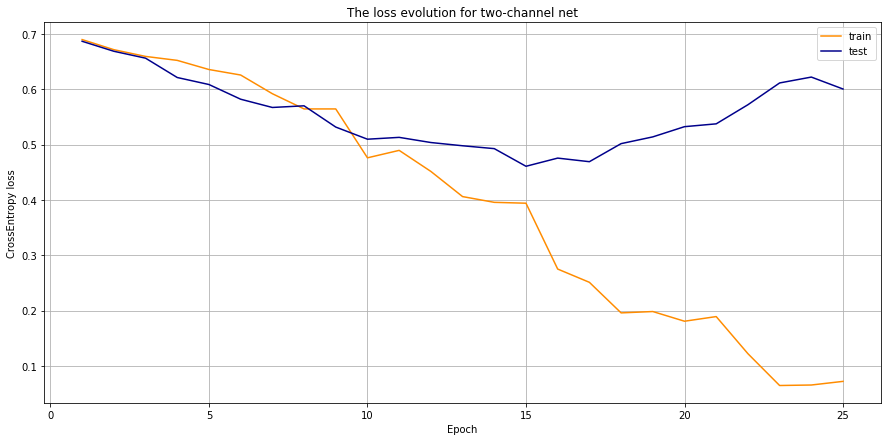

In [152]:
nb_epochs = 25

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net')
ax.legend();

## Convnet with two branches, each processes her own image.

In [62]:
def train_model_two_branch(model,dataloader = dataloader_train, mini_batch_size=100, test_inputs=None,
                test_targets=None, remember_train_losses=True, remember_test_losses=True, 
                lr=1e-3, nb_epochs=25):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model 
        dataloader : 
        
        mini_batch_size : int
            The size of the batch processing size
        train_inputs : torch.Tensor object
            The input test feature set
        train_targets : torch.Tensor object
            The input test label set
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list) or (NN object, list, list)
            If either remember_train_losses or remember_test_losses
            is True then the function returns both the trained model 
            and the list of train/test losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
            If both remember_train_losses or remember_test_losses
            are True then the function returns the trained model 
            and lists of train and test losses for each epoch.
    """
    
    if remember_train_losses:
        train_losses = []
    
    if remember_test_losses:
        test_losses = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for i, (train_input,train_target,_) in enumerate(dataloader_train):
            output = model(train_input[:, 0].view(mini_batch_size, 1, 14, 14), train_input[:, 1].view(mini_batch_size, 1, 14, 14))
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        
        if remember_train_losses:
            train_losses.append(loss)
        
        if remember_test_losses:
            #we are not using minibatches for test
            test_outputs = model(test_inputs[:, 0].view(-1, 1, 14, 14), test_inputs[:, 1].view(-1, 1, 14, 14))
            test_losses.append(criterion(test_outputs, test_targets))
            
        print('%dth epoch is finished and the train loss is %f' % (e + 1, loss))
           
    return model, train_losses, test_losses

def compute_nb_errors_two_branch(model, dataloader,mini_batch_size = 100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model  
        dataloader :
        
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    model = model.eval()
    # Processing the data set by mini batches
    for i, (data_input,target, _) in enumerate(dataloader):
        output = model(data_input[:, 0].view(mini_batch_size, 1, 14, 14), data_input[:, 1].view(mini_batch_size, 1, 14, 14))
        nb_errors += (((output > 0) & (target == 0)) | ((output <= 0) & (target == 1))).sum().item()
                
    return nb_errors

In [63]:
class TwoBranch(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranch, self).__init__()
        
        # Convolutional layers on the first branch
        self.cnn_first = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the first branch
        self.fc_first = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 1)
            
        )
        
        # Convolutional layers on the second branch
        self.cnn_second = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the second branch
        self.fc_second = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(10, 1)
            
        )
    
    def forward_first(self, x):
        x = self.cnn_first(x)
        x = x.view(x.size(0), -1)
        x = self.fc_first(x)
        return x
    
    def forward_second(self, x):
        x = self.cnn_second(x)
        x = x.view(x.size(0), -1)
        x = self.fc_second(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_first(input1)
        output_2 = self.forward_second(input2)
        output = (output_2 - output_1).view(-1)
        return output

In [64]:
two_branch_net = TwoBranch()
two_branch_net, train_losses, test_losses = \
    train_model_two_branch(two_branch_net, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.680186
2th epoch is finished and the train loss is 0.686496
3th epoch is finished and the train loss is 0.708695
4th epoch is finished and the train loss is 0.633531
5th epoch is finished and the train loss is 0.641671
6th epoch is finished and the train loss is 0.510451
7th epoch is finished and the train loss is 0.505361
8th epoch is finished and the train loss is 0.542039
9th epoch is finished and the train loss is 0.505880
10th epoch is finished and the train loss is 0.467988
11th epoch is finished and the train loss is 0.475782
12th epoch is finished and the train loss is 0.392023
13th epoch is finished and the train loss is 0.323969
14th epoch is finished and the train loss is 0.341113
15th epoch is finished and the train loss is 0.312545
16th epoch is finished and the train loss is 0.275082
17th epoch is finished and the train loss is 0.364676
18th epoch is finished and the train loss is 0.300279
19th epoch is finished and the train 

In [65]:
nb_errors_train = compute_nb_errors_two_branch(two_branch_net, dataloader_train)
nb_errors_test = compute_nb_errors_two_branch(two_branch_net, dataloader_test)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 967 out of 1000
Number of correct test classifications: 826 out of 1000


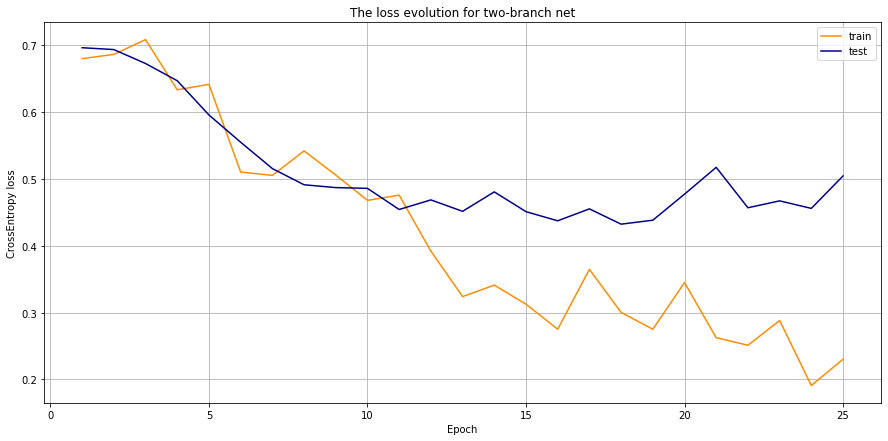

In [66]:
nb_epochs = 25

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-branch net')
ax.legend();

## Convnet with two branches, each processes her own image + weight sharing.

In [69]:
class TwoBranchSameWeight(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSameWeight, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(10, 1)
            
        )
        
    
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_single(input1)
        output_2 = self.forward_single(input2)
        output = (output_2 - output_1).view(-1)
        return output

In [70]:
two_branch_same_weight_net = TwoBranchSameWeight()
two_branch_same_weight_net, train_losses, test_losses = \
    train_model_two_branch(two_branch_same_weight_net, dataloader_train, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.671591
2th epoch is finished and the train loss is 0.628970
3th epoch is finished and the train loss is 0.511465
4th epoch is finished and the train loss is 0.536683
5th epoch is finished and the train loss is 0.497298
6th epoch is finished and the train loss is 0.448694
7th epoch is finished and the train loss is 0.433885
8th epoch is finished and the train loss is 0.326894
9th epoch is finished and the train loss is 0.334681
10th epoch is finished and the train loss is 0.358196
11th epoch is finished and the train loss is 0.323258
12th epoch is finished and the train loss is 0.260018
13th epoch is finished and the train loss is 0.267046
14th epoch is finished and the train loss is 0.259837
15th epoch is finished and the train loss is 0.245992
16th epoch is finished and the train loss is 0.240254
17th epoch is finished and the train loss is 0.203450
18th epoch is finished and the train loss is 0.173789
19th epoch is finished and the train 

In [71]:
nb_errors_train = compute_nb_errors_two_branch(two_branch_same_weight_net, dataloader_train)
nb_errors_test = compute_nb_errors_two_branch(two_branch_same_weight_net, dataloader_test)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 996 out of 1000
Number of correct test classifications: 851 out of 1000


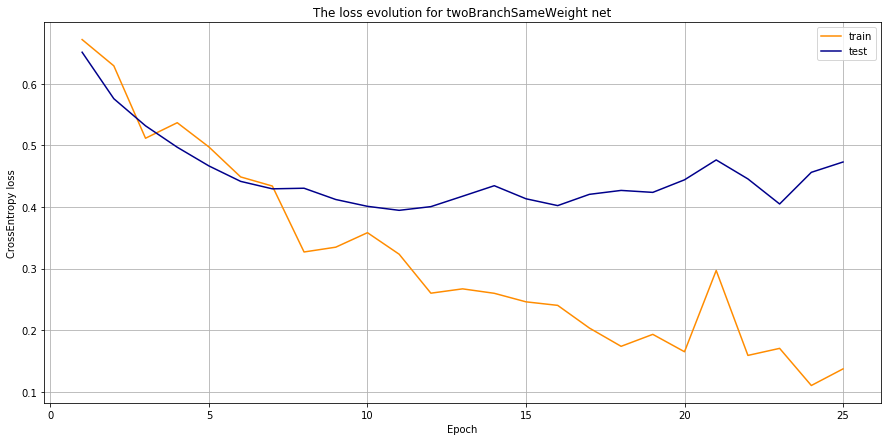

In [72]:
nb_epochs = 25

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for twoBranchSameWeight net')
ax.legend();

## Convnet with two branches, each processes her own image -> different architecture.

In [73]:
class TwoBranchSecond(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecond, self).__init__()
        
        # Convolutional layers on the first branch
        self.cnn_first = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the first branch
        self.fc_first = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Dropout(0.3)
            
        )
        
        # Convolutional layers on the second branch
        self.cnn_second = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the second branch
        self.fc_second = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            
        )
        
        self.fc_prefinal = nn.Linear(20, 10)
        self.fc_final = nn.Linear(10, 1)
    
    def forward_first(self, x):
        x = self.cnn_first(x)
        x = x.view(x.size(0), -1)
        x = self.fc_first(x)
        return x
    
    def forward_second(self, x):
        x = self.cnn_second(x)
        x = x.view(x.size(0), -1)
        x = self.fc_second(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_first(input1)
        output_2 = self.forward_second(input2)
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output = self.fc_final(output).view(-1)
        return output

In [74]:
two_branch_second_net = TwoBranchSecond()
two_branch_second_net, train_losses, test_losses = \
    train_model_two_branch(two_branch_second_net, dataloader_train, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.691289
2th epoch is finished and the train loss is 0.680970
3th epoch is finished and the train loss is 0.661997
4th epoch is finished and the train loss is 0.616668
5th epoch is finished and the train loss is 0.583590
6th epoch is finished and the train loss is 0.562102
7th epoch is finished and the train loss is 0.555889
8th epoch is finished and the train loss is 0.544790
9th epoch is finished and the train loss is 0.488495
10th epoch is finished and the train loss is 0.443435
11th epoch is finished and the train loss is 0.410601
12th epoch is finished and the train loss is 0.441577
13th epoch is finished and the train loss is 0.405939
14th epoch is finished and the train loss is 0.346354
15th epoch is finished and the train loss is 0.340312
16th epoch is finished and the train loss is 0.380692
17th epoch is finished and the train loss is 0.388876
18th epoch is finished and the train loss is 0.385882
19th epoch is finished and the train 

In [75]:
nb_errors_train = compute_nb_errors_two_branch(two_branch_second_net, dataloader_train)
nb_errors_test = compute_nb_errors_two_branch(two_branch_second_net, dataloader_test)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 967 out of 1000
Number of correct test classifications: 828 out of 1000


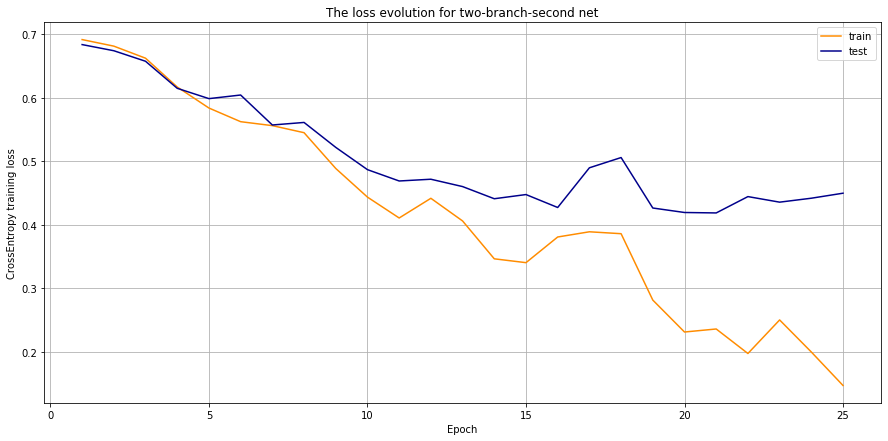

In [76]:
nb_epochs = 25

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-branch-second net')
ax.legend();

## Convnet with two branches, each processes her own image -> different architecture + weight sharing.

In [77]:
class TwoBranchSecondSameWeight(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecondSameWeight, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Dropout(0.3)
            
        )
        
        self.fc_prefinal = nn.Linear(20, 10)
        self.fc_final = nn.Linear(10, 1)
        
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_single(input1)
        output_2 = self.forward_single(input2)
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output = self.fc_final(output).view(-1)
        return output

In [78]:
two_branch_second_same_weight_net = TwoBranchSecondSameWeight()
two_branch_second_same_weight_net, train_losses, test_losses = \
    train_model_two_branch(two_branch_second_same_weight_net,dataloader_train, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.696688
2th epoch is finished and the train loss is 0.691460
3th epoch is finished and the train loss is 0.671313
4th epoch is finished and the train loss is 0.652194
5th epoch is finished and the train loss is 0.600201
6th epoch is finished and the train loss is 0.530203
7th epoch is finished and the train loss is 0.513008
8th epoch is finished and the train loss is 0.489902
9th epoch is finished and the train loss is 0.430920
10th epoch is finished and the train loss is 0.411892
11th epoch is finished and the train loss is 0.421424
12th epoch is finished and the train loss is 0.350003
13th epoch is finished and the train loss is 0.335849
14th epoch is finished and the train loss is 0.305299
15th epoch is finished and the train loss is 0.300517
16th epoch is finished and the train loss is 0.312190
17th epoch is finished and the train loss is 0.235668
18th epoch is finished and the train loss is 0.277474
19th epoch is finished and the train 

In [79]:
nb_errors_train = compute_nb_errors_two_branch(two_branch_second_same_weight_net, dataloader_train)
nb_errors_test = compute_nb_errors_two_branch(two_branch_second_same_weight_net, dataloader_test)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 973 out of 1000
Number of correct test classifications: 836 out of 1000


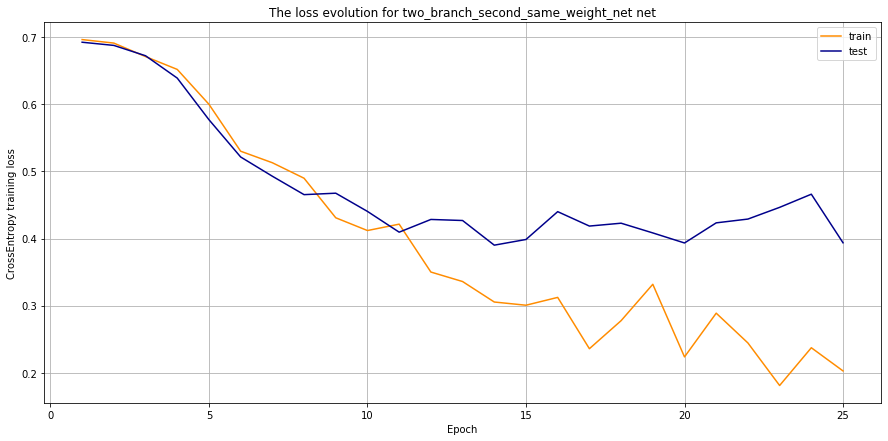

In [80]:
import matplotlib.pyplot as plt
nb_epochs = 25

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two_branch_second_same_weight_net net')
ax.legend();

## Convnet with two branches, each processes her own image -> different architecture + weight sharing + auxiliary losses.

In [42]:
def train_model_auxiliary(model, dataloader, mini_batch_size=100, test_inputs=None,
                test_targets=None, test_classes=None, remember_train_losses=True, remember_test_losses=True, 
                lr=1e-3, nb_epochs=25):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model 
        dataloader :
        
        mini_batch_size : int
            The size of the batch processing size
        test_inputs : torch.Tensor object
            The input test feature set
        test_targets : torch.Tensor object
            The input test label set
        test_classes : torch.Tensor object
            The input test classes set
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list) or (NN object, list, list)
            If either remember_train_losses or remember_test_losses
            is True then the function returns both the trained model 
            and the list of train/test losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
            If both remember_train_losses or remember_test_losses
            are True then the function returns the trained model 
            and lists of train and test losses for each epoch.
    """
    
    if remember_train_losses:
        train_losses = []
    
    if remember_test_losses:
        test_losses = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Defining the criterion for digit recognition
    criterion_digit = nn.CrossEntropyLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for i, (train_input, train_target, train_class) in enumerate(dataloader):
            output_comparison, output_first_digit, output_second_digit = \
                model(train_input[:, 0].view(mini_batch_size, 1, 14, 14), train_input[:, 1].view(mini_batch_size, 1, 14, 14))
            loss_comparison = criterion(output_comparison, train_target) 
            loss_first = criterion_digit(output_first_digit, train_class[:, 0])
            loss_second = criterion_digit(output_second_digit, train_class[:, 1])
            loss = loss_comparison + loss_first + loss_second
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        
        if remember_train_losses:
            train_losses.append(loss)
        
        if remember_test_losses:
            #we are not using minibatches for test
            test_comparison, test_first_digit, test_second_digit = \
                model(test_inputs[:, 0].view(-1, 1, 14, 14), test_inputs[:, 1].view(-1, 1, 14, 14))
            testloss_comparison = criterion(test_comparison, test_targets) 
            testloss_first = criterion_digit(test_first_digit, test_classes[:, 0])
            testloss_second = criterion_digit(test_second_digit, test_classes[:, 1])
            testloss = testloss_comparison + testloss_first + testloss_second
            test_losses.append(testloss)
            
        print('%dth epoch is finished and the train loss is %f' % (e + 1, loss))
           
    return model, train_losses, test_losses

def compute_nb_errors_auxiliary(model, dataloader, mini_batch_size=100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model
        dataloader : 
        
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    model = model.eval()
    # Processing the data set by mini batches
    for i, (data_input, target, _) in enumerate(dataloader):
        output, _, _ = model(data_input[:, 0].view(mini_batch_size, 1, 14, 14), data_input[:, 1].view(mini_batch_size, 1, 14, 14))
        nb_errors += (((output > 0) & (target == 0)) | ((output <= 0) & (target == 1))).sum().item()
                
    return nb_errors

In [43]:
class TwoBranchSecondSameWeightAuxiliaryLoss(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecondSameWeightAuxiliaryLoss, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Dropout(0.3)
            
        )
        
        self.fc_prefinal = nn.Linear(2*nb_hidden, 100)
        self.fc_comparison = nn.Linear(100, 1)
        self.fc_first_digit = nn.Linear(100, 10)
        self.fc_second_digit = nn.Linear(100, 10)
        
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_single(input1)
        output_2 = self.forward_single(input2)
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output_comparison = self.fc_comparison(output).view(-1)
        output_first_digit = self.fc_first_digit(output)
        output_second_digit = self.fc_second_digit(output)
        return output_comparison, output_first_digit, output_second_digit

In [44]:
two_branch_second_same_weight_auxiliary_net = TwoBranchSecondSameWeightAuxiliaryLoss()
two_branch_second_same_weight_auxiliary_net, train_losses, test_losses = \
    train_model_auxiliary(two_branch_second_same_weight_auxiliary_net, dataloader_train, test_inputs=test_inputs, test_targets=test_targets, test_classes=test_classes)

1th epoch is finished and the train loss is 5.198017
2th epoch is finished and the train loss is 4.861103
3th epoch is finished and the train loss is 3.918466
4th epoch is finished and the train loss is 2.853353
5th epoch is finished and the train loss is 2.311855
6th epoch is finished and the train loss is 1.765487
7th epoch is finished and the train loss is 1.586315
8th epoch is finished and the train loss is 1.318243
9th epoch is finished and the train loss is 1.033080
10th epoch is finished and the train loss is 0.919319
11th epoch is finished and the train loss is 0.875535
12th epoch is finished and the train loss is 0.805721
13th epoch is finished and the train loss is 0.714223
14th epoch is finished and the train loss is 0.602326
15th epoch is finished and the train loss is 0.577114
16th epoch is finished and the train loss is 0.589091
17th epoch is finished and the train loss is 0.562648
18th epoch is finished and the train loss is 0.451349
19th epoch is finished and the train 

In [45]:
nb_errors_train = compute_nb_errors_auxiliary(two_branch_second_same_weight_auxiliary_net, dataloader_train)
nb_errors_test = compute_nb_errors_auxiliary(two_branch_second_same_weight_auxiliary_net, dataloader_test)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 943 out of 1000
Number of correct test classifications: 892 out of 1000


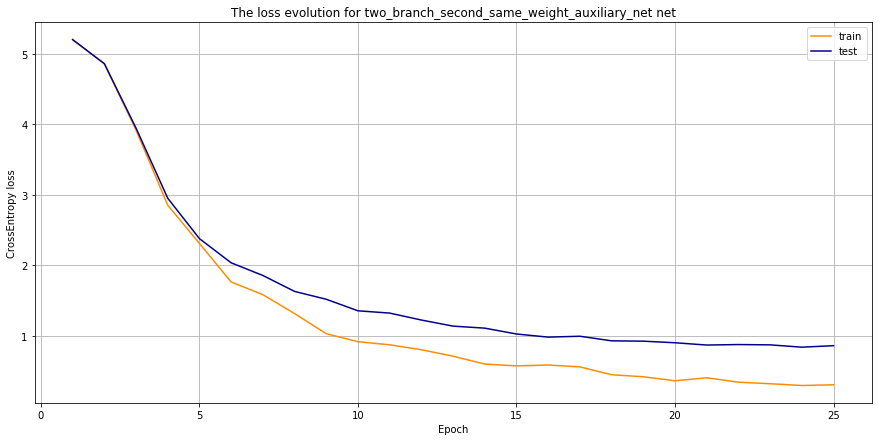

In [46]:
nb_epochs = 25

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two_branch_second_same_weight_auxiliary_net net')
ax.legend();

¯\_(ツ)_/¯

Stuff to do:
- Add Dropout to tackle the overfitting. DONE - it's better than before but somehow too discontinuous, only the last doesn't overfit at all
- 800/900 number of samples for training set, and 200/100 number of sample for validation set
- Use DataLoader instead of .split(mini_batch_size) - DONE
- Instead of CrossEntropy loss for the figures - use error rate